# Computer Vision Face Expression Detection Using Convolutional Neural Networks and Deep Learning with Pytorch
---

- Fine-Tuning pre-trained models
- Training and validating during the train loop
- Detailed evaluation report

## Mounting Google Drive
---

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Debug
print(IN_COLAB)
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

True
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import the required libraries
---

In [ ]:
import os
import random
import time
import platform
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
import torch.nn.functional as F
from torch import nn, optim

from torch.optim import lr_scheduler

from torchvision import transforms, models, datasets, utils

## Setting for reporducibility
---

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Checking GPU Access
---

In [ ]:
# Check if the GPU is available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


In [ ]:
!nvidia-smi

Wed Aug 13 18:32:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## The dataset
---

In [ ]:
if IN_COLAB:
  ds_path = '/content/drive/My Drive/Data/faces-emotion-recognition/faces/'
else:
  ds_path = '/home/'

## Seting up the experiment folder
---

In [ ]:
EXP_PATH = '/content/drive/My Drive/exp-fer_p3_01/'
if not os.path.exists(EXP_PATH):
    os.makedirs(EXP_PATH)

## Setting some hyperparameters
---

In [ ]:
# Batch size (mini-batch size)
batch_size = 64
# Learning rate
lr = 0.001
# Mommentum
mm = 0.9
# Number of training epochs
epochs = 30 # Use a small value during development, 2 for example.
# Step size - For the learning rate scheduler (StepLR).
ss = 10

In [ ]:
# Select the network architecture.
ARCH_NAME = 'resnet18' # 'simplenet', 'alexnet', 'resnet18', ...
# Note: 'simplenet' refers to the architecture we developed.
# For information on additional architectures, please refer to the torchvision documentation: https://pytorch.org/vision/stable/models.html.

## Preparing the dataset
---

In [ ]:
# Data transforms
data_transforms = transforms.Compose([
    # It is necessary to resize the image to match the network's input size.
    transforms.Resize(size=(224, 224,)),
    transforms.ToTensor(),
    # Mean and standard deviation of ImageNet
    # These are required as we will use a model pre-trained on ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Builds a dataset from a directory
# The directory must contain a subdirectory for each class in the problem
full_dataset = datasets.ImageFolder(ds_path, transform=data_transforms)

# Class names
class_names = full_dataset.classes
print("Class names: ", class_names)

num_classes = len(class_names)

Class names:  ['angry', 'fear', 'happy', 'neutral', 'sad']


## Visualizing some images
---

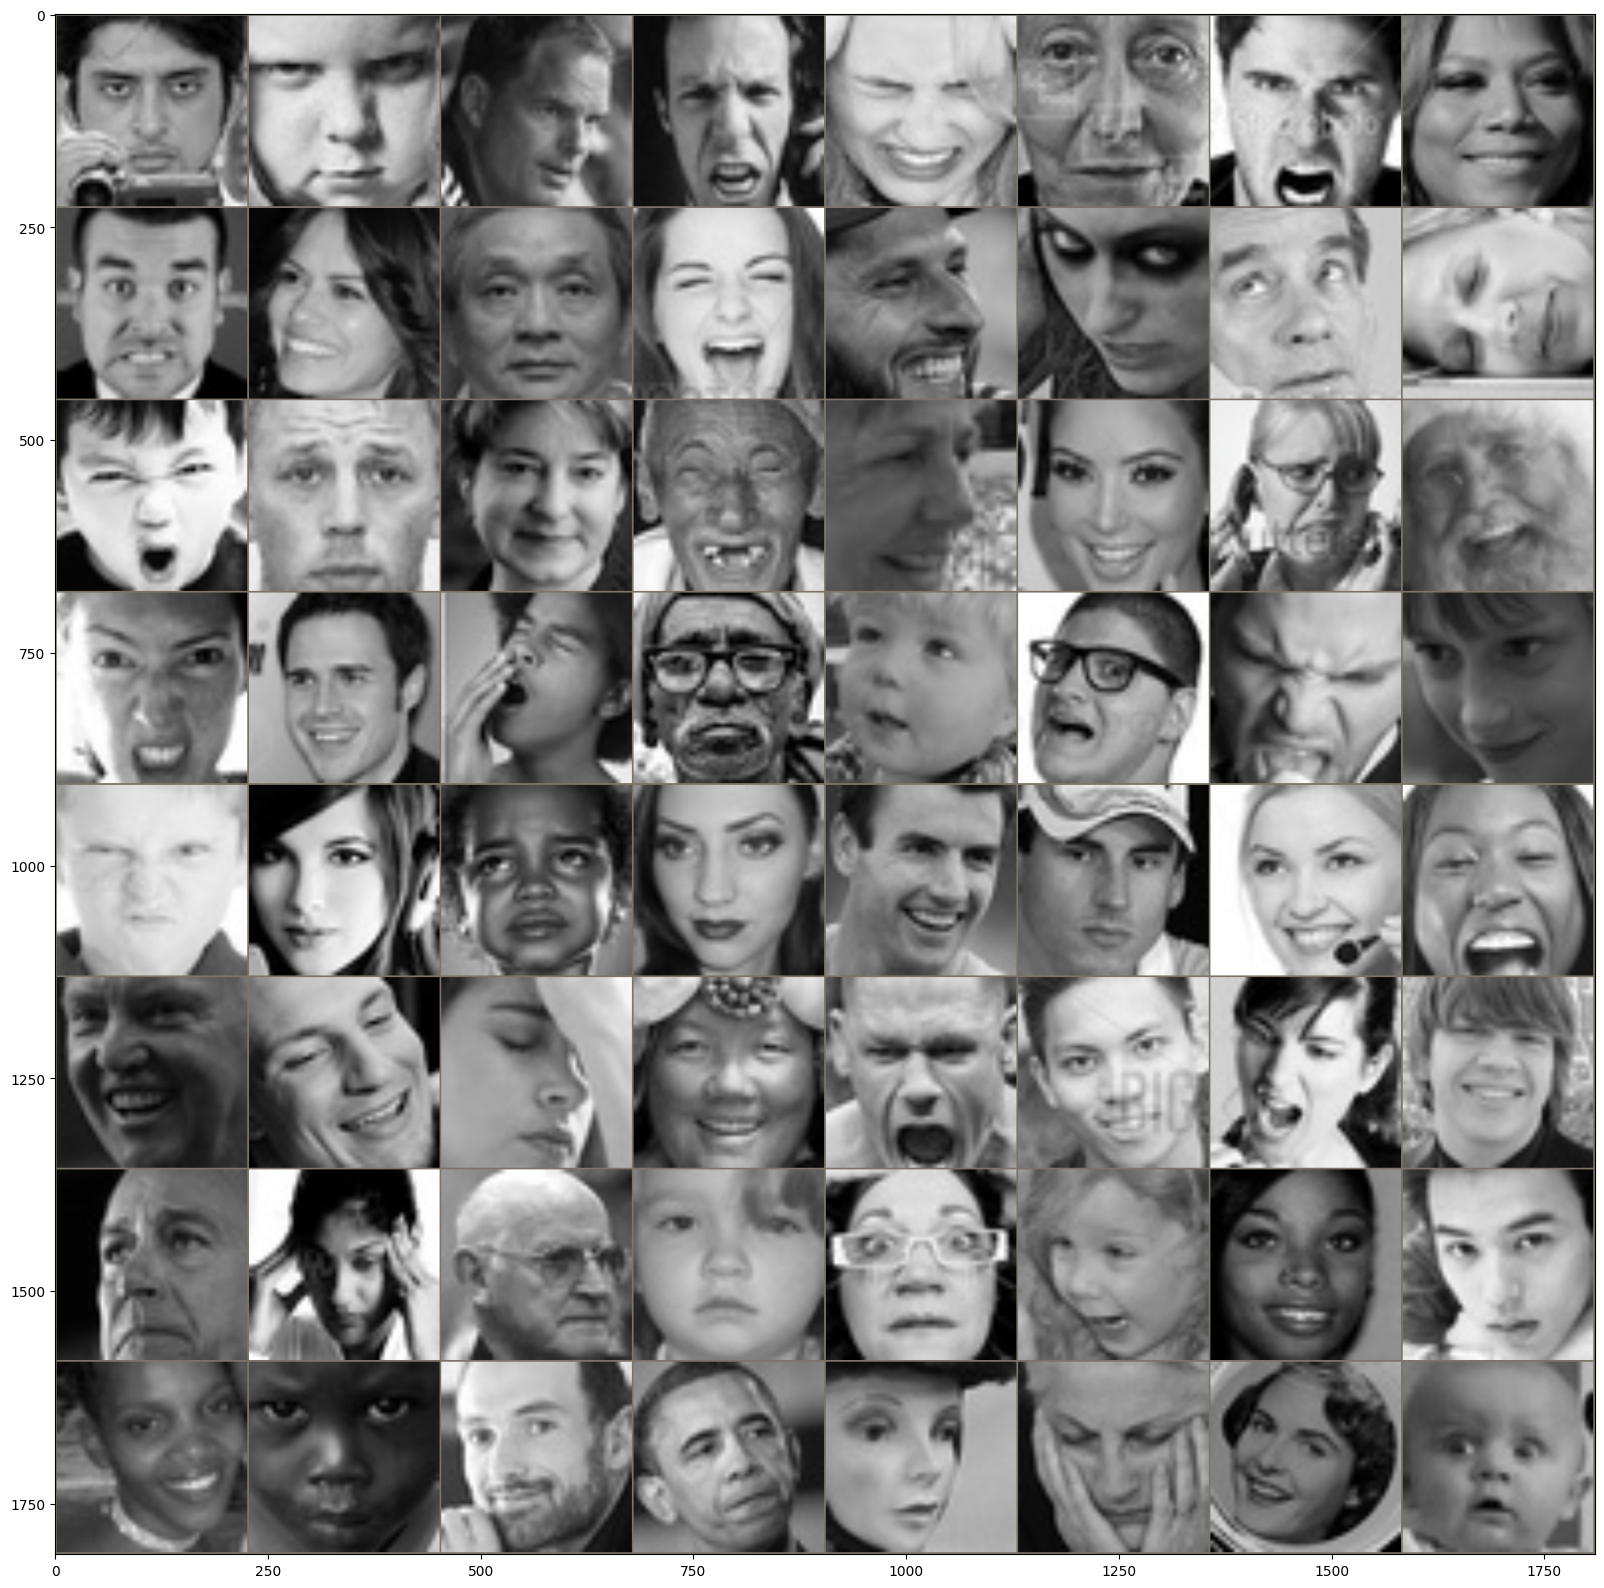

In [ ]:
def show_transformed_image(image):
  # Unormalize the channels.ImageNet weights.
  for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
    t.mul_(s).add_(m)

  np_image = image.numpy()

  plt.figure(figsize=(20, 20))
  plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Visualize `batch_size` images
dataloader_vis = torch.utils.data.DataLoader(dataset=full_dataset, shuffle=True, batch_size=64)
items = iter(dataloader_vis)
image, label = next(items)

show_transformed_image(utils.make_grid(image))

## Spliting the dataset in training and test sets
---

In [ ]:
# Training set: 80%
train_size = int(0.8 * len(full_dataset))

# Validation set: 20%
test_size = len(full_dataset) - train_size

# Spliting the full dataset
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Number of images in each split
train_size = len(train_dataset)
val_size = len(val_dataset)

print(train_size)
print(val_size)

# Defining the dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, pin_memory=True, num_workers=2)

19956
4989


## Data Manipulation
---

torch.Size([3, 224, 224])
tensor(2)


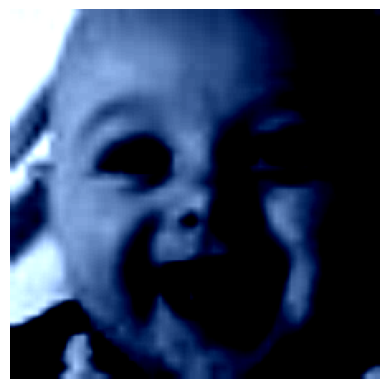

In [ ]:
# Class names:  ['angry', 'fear', 'happy', 'neutral', 'sad']

for data in train_dataloader:
  x, y = data[0][24], data[1][24]
  break

print(x.shape)
print(y.data)

x = x.permute(1, 2, 0)
image_np = x.squeeze(0).numpy()

plt.imshow(image_np, cmap='gray')
plt.axis('off')
plt.show()

## Define the CNN Architecture
---

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Net(nn.Module):
    """
    Considering each image having 224 x 224 x 3:

    Input [3, 224, 224]
    Conv1(3, 6, 5) [6, 220, 220]
    Pool(2, 2) 16, 110, 110]
    Conv2(6, 16, 5) [16, 106, 106]
    Pool(2, 2) [16, 53, 53]
    Flatten [44944] (16 x 53 x 53 = 44944)
    Fc1 [120]
    Fc2 [84]
    Fc3 [5]
    """
    def __init__(self, in_channels, num_classes):
        """
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
                        dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # conv1(x): Input: [224, 224, 3]. Output: [220, 220, 6].
        x = self.conv1(x)
        x = F.relu(x)
        # pool: Input: [220, 220, 6], Output: [110, 110, 6]
        x = self.pool(x)
        # conv2: Input: [110, 110, 6]. Output: [106, 106, 16].
        x = self.conv2(x)
        x = F.relu(x)
        # pool: Input: [106, 106, 16], Output: [53, 53, 16]
        x = self.pool(x)
        # flatten: Input: [53, 53, 16]. Output: [44944]
        x = torch.flatten(x, 1)
        # fc1: Input: [44944]. Output: [120]
        x = self.fc1(x)
        x = F.relu(x)
        # fc2: Input: [120]. Output: [84]
        x = self.fc2(x)
        x = F.relu(x)
        # fc3: Input: [80]. Output: [num_classes]
        x = self.fc3(x)

        return F.softmax(x, dim=1)

## Using a pretrained model (fine-tunning)
---

## Selecting the model
- https://pytorch.org/vision/stable/models.html
----

In [ ]:
if ARCH_NAME == 'simplenet':
    # Simple net
    model = Net(3, num_classes)

elif ARCH_NAME == 'alexnet':
    # Pretrainned
    model = models.alexnet(weights='AlexNet_Weights.DEFAULT')
    ### model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
    # Changes the number of neurons in the output layer.
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)

elif ARCH_NAME == 'resnet18':
    model = models.resnet18(weights='ResNet18_Weights.DEFAULT')

    for param in model.parameters():
      param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

# Include more architectures...
# ---
### elif ARCH_NAME == ...

In [ ]:
# Send the model to the GPU
if DEVICE.type == 'cuda':
    model = model.cuda() # Cuda

# Print the model
print(str(model))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Loss function and optimizer
---

In [ ]:
# Loss function
# https://pytorch.org/docs/stable/nn.html
criterion = nn.CrossEntropyLoss()

# Optimizer
# https://pytorch.org/docs/stable/optim.html
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)

# Learning rate scheduler
# https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
scheduler = lr_scheduler.StepLR(optimizer, step_size=ss)

In [ ]:
# Pré-aquecimento da GPU (só se tiver CUDA disponível)
if DEVICE.type == "cuda":
    with torch.no_grad():
        dummy = torch.randn(1, 3, 224, 224, device=DEVICE)
        _ = model(dummy)

## Training the model
---

In [ ]:
# Total training time (including training and validation).
time_total_start = time.time()

# List of training losses and accuracies for each epoch.
train_loss_list = []
train_acc_list = []

# List of validation losses and accuracies for each epoch.
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    # TRAINING
    # =========================================================================
    # Starts timing the epoch.
    time_epoch_start = time.time()

    # Enables the model for training mode
    model.train()

    # Loss for this epoch.
    loss_epoch_train = 0.0
    # Samples correctly classified in this epoch.
    hits_epoch_train = 0

    # Iterate along the batches of the TRAINING SET
    for i, (inputs, labels) in enumerate(tqdm(train_dataloader, total= len(train_dataloader), desc="Training")):
        # Send data to GPU
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Enable gradient calculation during training.
        torch.set_grad_enabled(True)

        # -----> FORWARD
        # Model output
        outputs = model(inputs)

        # 'outputs' contains float values. Take the maximum values as the predictions.
        preds = torch.argmax(outputs, dim=1).float()

        # Compute the loss function
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward()

        # Optimizes the parameters (weights)
        optimizer.step()

        # Updates the epoch loss
        loss_epoch_train += float(loss.item()) * inputs.size(0)

        # Updates the epoch hits
        hits_epoch_train += torch.sum(preds == labels.data)

    # Training loss and accuracy for this epoch.
    train_loss = loss_epoch_train / train_size
    train_acc = float(hits_epoch_train.double() / train_size)

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # VALIDATION
    # =========================================================================
    model.eval()

    # Epoch validation loss
    loss_epoch_val = 0.0
    # Num hits for this epoch
    hits_epoch_val = 0

    # Iterate along the batches of the VALIDATION SET
    for inputs, labels in val_dataloader:

        # Send data to GPU
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Disables gradient calculation during validation.
        torch.set_grad_enabled(False)

        # -----> FORWARD
        # Model output
        outputs = model(inputs)

        # Returns the largest prediction.
        preds = torch.argmax(outputs, dim=1).float()

        # Compute the loss
        loss = criterion(outputs, labels)

        # Updates the epoch loss
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        # Updates the epoch hits
        hits_epoch_val += torch.sum(preds == labels.data)

    # Adjust the learning rate
    scheduler.step()

    # Validation loss and accuracy for this epoch.
    val_loss = loss_epoch_val / val_size
    val_acc = float(hits_epoch_val.double() / val_size)

    # Store val loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Total time for this epoch
    time_epoch = int(time.time() - time_epoch_start)

    # PRINTING
    # --------
    print(f"Epoch {epoch}/{ epochs - 1} \
      - TRAIN Loss: {train_loss:.4f} \
      - TRAIN Acc: {train_acc:.4f} \
      - VAL. Loss: {val_loss:.4f} \
      - VAL. Acc: {val_acc:.4f} \
      ({int(time_epoch // 60)}m {int(time_epoch % 60)}s)")

# Total training time
time_total_train = time.time() - time_total_start

# PRINTING
print(f'\nTraining finished! ({int(time_total_train // 60)}m {int(time_total_train % 60)}s)')

Training: 100%|██████████| 312/312 [01:55<00:00,  2.70it/s]


Epoch 0/29       - TRAIN Loss: 1.4911       - TRAIN Acc: 0.3630       - VAL. Loss: 1.3889       - VAL. Acc: 0.4195       (2m 17s)


Training: 100%|██████████| 312/312 [01:15<00:00,  4.16it/s]


Epoch 1/29       - TRAIN Loss: 1.3849       - TRAIN Acc: 0.4297       - VAL. Loss: 1.3569       - VAL. Acc: 0.4434       (1m 35s)


Training: 100%|██████████| 312/312 [01:17<00:00,  4.03it/s]


Epoch 2/29       - TRAIN Loss: 1.3522       - TRAIN Acc: 0.4485       - VAL. Loss: 1.3412       - VAL. Acc: 0.4496       (1m 38s)


Training: 100%|██████████| 312/312 [01:19<00:00,  3.90it/s]


Epoch 3/29       - TRAIN Loss: 1.3368       - TRAIN Acc: 0.4528       - VAL. Loss: 1.3318       - VAL. Acc: 0.4526       (1m 38s)


Training: 100%|██████████| 312/312 [01:16<00:00,  4.06it/s]


Epoch 4/29       - TRAIN Loss: 1.3204       - TRAIN Acc: 0.4632       - VAL. Loss: 1.3246       - VAL. Acc: 0.4652       (1m 34s)


Training: 100%|██████████| 312/312 [01:13<00:00,  4.22it/s]


Epoch 5/29       - TRAIN Loss: 1.3189       - TRAIN Acc: 0.4622       - VAL. Loss: 1.3306       - VAL. Acc: 0.4618       (1m 32s)


Training: 100%|██████████| 312/312 [01:13<00:00,  4.27it/s]


Epoch 6/29       - TRAIN Loss: 1.3130       - TRAIN Acc: 0.4657       - VAL. Loss: 1.3183       - VAL. Acc: 0.4652       (1m 31s)


Training: 100%|██████████| 312/312 [01:14<00:00,  4.18it/s]


Epoch 7/29       - TRAIN Loss: 1.3070       - TRAIN Acc: 0.4709       - VAL. Loss: 1.3308       - VAL. Acc: 0.4554       (1m 33s)


Training: 100%|██████████| 312/312 [01:14<00:00,  4.21it/s]


Epoch 8/29       - TRAIN Loss: 1.3059       - TRAIN Acc: 0.4689       - VAL. Loss: 1.3167       - VAL. Acc: 0.4612       (1m 32s)


Training: 100%|██████████| 312/312 [01:15<00:00,  4.14it/s]


Epoch 9/29       - TRAIN Loss: 1.3064       - TRAIN Acc: 0.4698       - VAL. Loss: 1.3243       - VAL. Acc: 0.4666       (1m 33s)


Training: 100%|██████████| 312/312 [01:14<00:00,  4.21it/s]


Epoch 10/29       - TRAIN Loss: 1.2797       - TRAIN Acc: 0.4832       - VAL. Loss: 1.3104       - VAL. Acc: 0.4636       (1m 31s)


Training: 100%|██████████| 312/312 [01:14<00:00,  4.18it/s]


Epoch 11/29       - TRAIN Loss: 1.2796       - TRAIN Acc: 0.4846       - VAL. Loss: 1.3108       - VAL. Acc: 0.4680       (1m 32s)


Training: 100%|██████████| 312/312 [01:13<00:00,  4.22it/s]


Epoch 12/29       - TRAIN Loss: 1.2789       - TRAIN Acc: 0.4855       - VAL. Loss: 1.3098       - VAL. Acc: 0.4656       (1m 32s)


Training: 100%|██████████| 312/312 [01:13<00:00,  4.22it/s]


Epoch 13/29       - TRAIN Loss: 1.2803       - TRAIN Acc: 0.4833       - VAL. Loss: 1.3097       - VAL. Acc: 0.4638       (1m 33s)


Training: 100%|██████████| 312/312 [01:15<00:00,  4.12it/s]


Epoch 14/29       - TRAIN Loss: 1.2792       - TRAIN Acc: 0.4822       - VAL. Loss: 1.3112       - VAL. Acc: 0.4686       (1m 35s)


Training: 100%|██████████| 312/312 [01:14<00:00,  4.21it/s]


Epoch 15/29       - TRAIN Loss: 1.2773       - TRAIN Acc: 0.4828       - VAL. Loss: 1.3117       - VAL. Acc: 0.4638       (1m 33s)


Training: 100%|██████████| 312/312 [01:14<00:00,  4.17it/s]


Epoch 16/29       - TRAIN Loss: 1.2789       - TRAIN Acc: 0.4828       - VAL. Loss: 1.3105       - VAL. Acc: 0.4668       (1m 33s)


Training: 100%|██████████| 312/312 [01:14<00:00,  4.20it/s]


Epoch 17/29       - TRAIN Loss: 1.2779       - TRAIN Acc: 0.4853       - VAL. Loss: 1.3105       - VAL. Acc: 0.4684       (1m 33s)


Training: 100%|██████████| 312/312 [01:15<00:00,  4.12it/s]


Epoch 18/29       - TRAIN Loss: 1.2761       - TRAIN Acc: 0.4853       - VAL. Loss: 1.3107       - VAL. Acc: 0.4626       (1m 35s)


Training: 100%|██████████| 312/312 [01:16<00:00,  4.07it/s]


Epoch 19/29       - TRAIN Loss: 1.2773       - TRAIN Acc: 0.4821       - VAL. Loss: 1.3096       - VAL. Acc: 0.4628       (1m 35s)


Training: 100%|██████████| 312/312 [01:15<00:00,  4.13it/s]


Epoch 20/29       - TRAIN Loss: 1.2769       - TRAIN Acc: 0.4854       - VAL. Loss: 1.3102       - VAL. Acc: 0.4666       (1m 33s)


Training: 100%|██████████| 312/312 [01:15<00:00,  4.15it/s]


Epoch 21/29       - TRAIN Loss: 1.2743       - TRAIN Acc: 0.4835       - VAL. Loss: 1.3091       - VAL. Acc: 0.4676       (1m 33s)


Training: 100%|██████████| 312/312 [01:16<00:00,  4.09it/s]


Epoch 22/29       - TRAIN Loss: 1.2742       - TRAIN Acc: 0.4864       - VAL. Loss: 1.3111       - VAL. Acc: 0.4640       (1m 34s)


Training: 100%|██████████| 312/312 [01:15<00:00,  4.12it/s]


Epoch 23/29       - TRAIN Loss: 1.2755       - TRAIN Acc: 0.4859       - VAL. Loss: 1.3107       - VAL. Acc: 0.4640       (1m 33s)


Training: 100%|██████████| 312/312 [01:18<00:00,  3.97it/s]


Epoch 24/29       - TRAIN Loss: 1.2733       - TRAIN Acc: 0.4877       - VAL. Loss: 1.3097       - VAL. Acc: 0.4674       (1m 37s)


Training: 100%|██████████| 312/312 [01:17<00:00,  4.03it/s]


Epoch 25/29       - TRAIN Loss: 1.2752       - TRAIN Acc: 0.4831       - VAL. Loss: 1.3096       - VAL. Acc: 0.4648       (1m 35s)


Training: 100%|██████████| 312/312 [01:14<00:00,  4.17it/s]


Epoch 26/29       - TRAIN Loss: 1.2765       - TRAIN Acc: 0.4866       - VAL. Loss: 1.3104       - VAL. Acc: 0.4652       (1m 33s)


Training: 100%|██████████| 312/312 [01:14<00:00,  4.19it/s]


Epoch 27/29       - TRAIN Loss: 1.2742       - TRAIN Acc: 0.4856       - VAL. Loss: 1.3107       - VAL. Acc: 0.4652       (1m 32s)


Training: 100%|██████████| 312/312 [01:15<00:00,  4.15it/s]


Epoch 28/29       - TRAIN Loss: 1.2758       - TRAIN Acc: 0.4870       - VAL. Loss: 1.3100       - VAL. Acc: 0.4692       (1m 33s)


Training: 100%|██████████| 312/312 [01:25<00:00,  3.67it/s]


Epoch 29/29       - TRAIN Loss: 1.2750       - TRAIN Acc: 0.4883       - VAL. Loss: 1.3105       - VAL. Acc: 0.4656       (1m 43s)

Training finished! (47m 56s)


## Saving and Load the trained model
---

In [ ]:
torch.save(model.state_dict(), os.path.join(EXP_PATH, f"fer-classification-{ARCH_NAME}-model.pth"))

## Analyzing the training
---

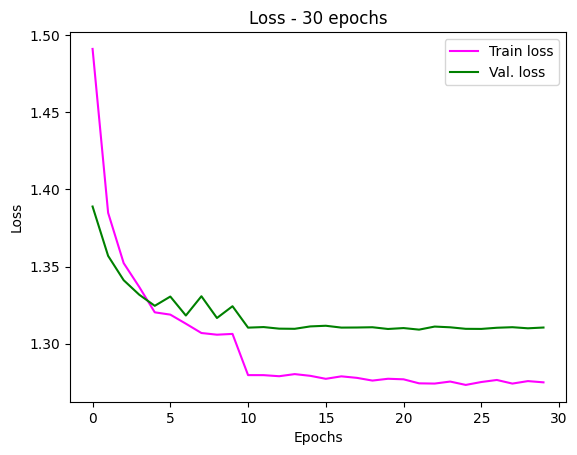

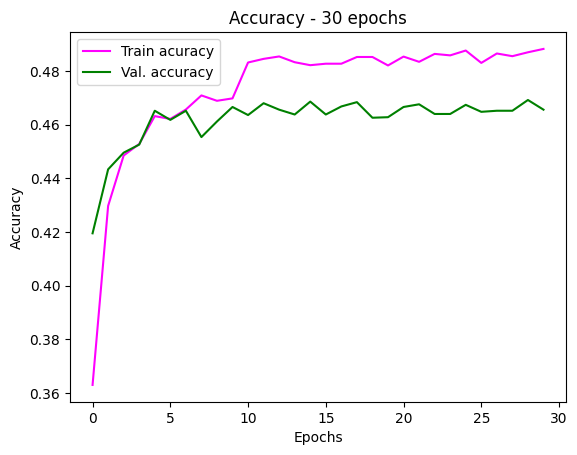

In [ ]:
# List with epoch indexes. [0, 1, ... num_epochs - 1]
epochs_list = list(range(len(train_loss_list)))

# Plot - Loss
plt.figure()
plt.title(f'Loss - {epochs} epochs')
plt.plot(epochs_list, train_loss_list, c='magenta', ls='-', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_loss_list, c='green', ls='-', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

# Plot - Accuracy
plt.figure()
plt.title(f'Accuracy - {epochs} epochs')
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train acuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

## Evaluating the model over the test set
---

In [ ]:
# List with true and predicted classes
true_val_list = []
pred_val_list = []
# List with probabilities
prob_val_list = []

# Iterate along the batches of the VALIDATION SET
for i, (img_list, label_list) in enumerate(val_dataloader):
    # Send data to GPU
    img_list = img_list.to(DEVICE)
    labelList = label_list.to(DEVICE)

    # Disables gradient calculation during validation and testing.
    torch.set_grad_enabled(False)

    # -----> FORWARD
    # Model output
    outputs = model(img_list)

    # Prediction
    preds = torch.argmax(outputs, dim=1)

    # Computes probabilities of each class
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)

    # True classes and predicted classes for this batch.
    if DEVICE.type == 'cuda':
        true_val_batch = list(label_list.cpu())
        pred_val_batch = list(preds.cpu())
        prob_val_batch = list(outputs_prob.cpu())
    else:
        true_val_batch = list(label_list)
        pred_val_batch = list(preds)
        prob_val_batch = list(outputs_prob)

    # Append batch results to the lists
    true_val_list += true_val_batch
    pred_val_list += pred_val_batch

    prob_val_list += prob_val_batch

## Confusion matrix and classification report
---

In [ ]:
# Confusion matrix
conf_mat_val = metrics.confusion_matrix(true_val_list, pred_val_list)
print('\nConfusion matrix (validation)')
print(conf_mat_val)

# Classification report - Scikit-learn
class_rep_val = metrics.classification_report(true_val_list, pred_val_list,
                                              target_names=class_names, digits=4,
                                              zero_division=0)
print('\nClass. report (validation)')
print(class_rep_val)

# Accuracy
acc_val = metrics.accuracy_score(true_val_list, pred_val_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_val))


Confusion matrix (validation)
[[ 73  53  41  17  39]
 [ 35  98  27  26  33]
 [ 19  27 165  25  21]
 [ 28  20  38  60  16]
 [ 17  44  37  24  61]]

Class. report (validation)
              precision    recall  f1-score   support

       angry     0.4244    0.3274    0.3696       223
        fear     0.4050    0.4475    0.4252       219
       happy     0.5357    0.6420    0.5841       257
     neutral     0.3947    0.3704    0.3822       162
         sad     0.3588    0.3333    0.3456       183

    accuracy                         0.4377      1044
   macro avg     0.4237    0.4241    0.4213      1044
weighted avg     0.4316    0.4377    0.4318      1044



Validation Acc.: 0.4377
